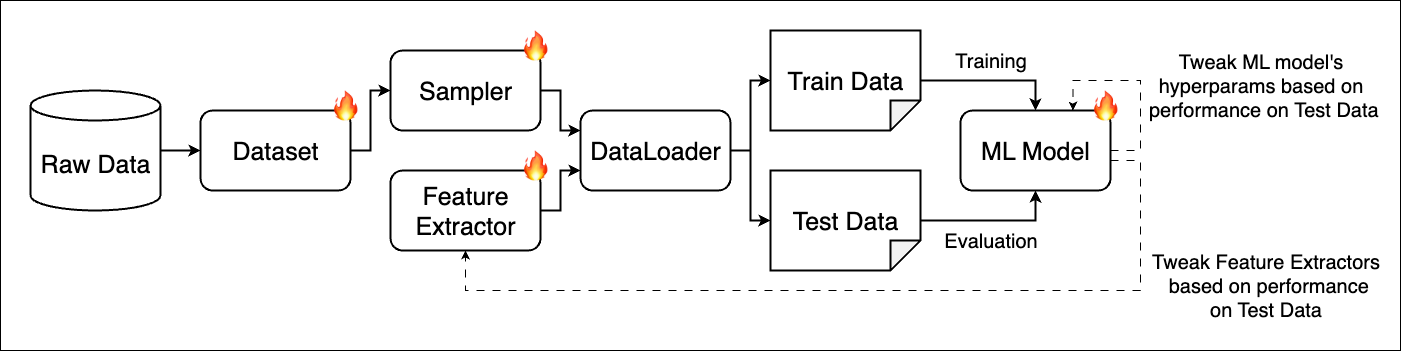

# Assignment 1
## ✅ Rename the filename with your roll number. E.g. if your roll number is `MT24003` then rename the file `MT24003_a2.ipynb` before submitting.
## ✅ Write code only in the sections marked with `# YOUR CODE HERE`. No, you can NOT write code anywhere else.
## ✅ Download and extract the `data.zip` folder next to this file. If you extract it correctly, you will have a `data` folder next to this file.
## ❌ Do not modify any other function or class definitions; doing so may lead to the autograder failing to judge your submission, resulting in a zero.
## ❌ Deleting or adding new cells may lead to the `autograder` failing to judge your submission, resulting in a zero. Even if a cell is empty, do NOT delete it.
## ❌ Do NOT install / import any other libraries. You should be able to solve all the questions using only the libraries imported below.


In [8]:
import os
import json
import glob
import random
from typing import Dict, List, Any, Tuple, Optional
from abc import ABC, abstractmethod

import numpy as np
from PIL import Image
import librosa
import scipy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

PATH_TO_DATA_DIR = "./MLA2_DATA"
PATH_TO_TRAIN_DIR = os.path.join(PATH_TO_DATA_DIR, "TRAIN")
PATH_TO_TEST_DIR = os.path.join(PATH_TO_DATA_DIR, "TEST")

PATH_TO_IMAGE_TRAIN_DIR = os.path.join(PATH_TO_TRAIN_DIR, "IMAGE")
PATH_TO_AUDIO_TRAIN_DIR = os.path.join(PATH_TO_TRAIN_DIR, "AUDIO")
PATH_TO_TEXT_TRAIN_DIR = os.path.join(PATH_TO_TRAIN_DIR, "TEXT")

PATH_TO_IMAGE_TEST_DIR = os.path.join(PATH_TO_TEST_DIR, "IMAGE")
PATH_TO_AUDIO_TEST_DIR = os.path.join(PATH_TO_TEST_DIR, "AUDIO")
PATH_TO_TEXT_TEST_DIR = os.path.join(PATH_TO_TEST_DIR, "TEXT")

# `q1` Data Loading and Preprocessing

1. Populate the functions in all the Dataset classes in the following code cell only where the `### YOUR CODE HERE` marker is present.
2. Follow the instructions in the doc strings of the functions to implement the functions.
3. Grading [total: 1.5]
   1. `ImageDataset` class compiles and passes hidden tests with no errors: 0.5
   2. `AudioDataset` class compiles and passes hidden tests with no errors: 0.5
   3. `TextDataset` class compiles and passes hidden tests with no errors: 0.5

In [9]:
############################
# Q1: Datasets
############################


class BaseDataset(ABC):
    """
    Shared interface for modality-specific datasets.

    Attributes
    - modality: string describing modality ("image" | "audio" | "text"). Set by subclasses.
    """

    def __init__(self, data_dir: str):
        self.data_dir: str = data_dir
        self.modality: str = ""

    @abstractmethod
    def __len__(self) -> int:
        ...

    @abstractmethod
    def __getitem__(self, idx: int) -> Dict[str, Any]:
        ...


class ImageDataset(BaseDataset):
    """
    Load images organized under per-class folders.
    """

    def __init__(self, path_to_image_data_dir: str = PATH_TO_IMAGE_TRAIN_DIR):
        super().__init__(path_to_image_data_dir)
        self.modality = "image"
        self.records = []

        ### YOUR CODE HERE
        cds = [d for d in sorted(glob.glob(os.path.join(self.data_dir, "*"))) if os.path.isdir(d)]
        for cd in cds:
            label = os.path.basename(cd)
            img_files = []
            img_files.extend(glob.glob(os.path.join(cd, "*.jpg")))
            for fp in sorted(img_files):
                self.records.append({"path": fp, "class": label})

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        record = {
            "class": None,
        }
        ### YOUR CODE HERE
        item = self.records[idx]
        img = Image.open(item["path"]).convert("RGB")   # force RGB
        record["class"] = item["class"]
        record["image"] = np.array(img)
        return record

class AudioDataset(BaseDataset):
    """
    Load WAV files and metadata.
    """

    def __init__(self, path_to_audio_data_dir: str = PATH_TO_AUDIO_TRAIN_DIR):
        super().__init__(path_to_audio_data_dir)
        self.modality = "audio"
        self.records = []

        ### YOUR CODE HERE
        wav_files = sorted(glob.glob(os.path.join(self.data_dir, "*.wav")))
        for fp in wav_files:
            base = os.path.splitext(os.path.basename(fp))[0]
            label = base.split("_")[-1]                  
            self.records.append({"path": fp, "class": label})

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        record = {
            "class": None,
        }
        ### YOUR CODE HERE
        item = self.records[idx]
        audio, sr = librosa.load(item["path"], sr=None, mono=True)
        record["class"] = item["class"]
        record["audio"] = audio
        record["sr"] = sr
        return record

class TextDataset(BaseDataset):
    """
    Load text data.
    """

    def __init__(self, path_to_text_data_dir: str = PATH_TO_TEXT_TRAIN_DIR):
        super().__init__(path_to_text_data_dir)
        self.modality = "text"
        self.records = []

        ### YOUR CODE HERE
        candidates = []
        p = os.path.join(self.data_dir, "train.jsonl")
        if os.path.isfile(p):
            candidates.append(p)
        if not candidates:
            candidates = sorted(glob.glob(os.path.join(self.data_dir, "*.jsonl")))
        if not candidates:
            return
        jsonl_path = candidates[0]
        with open(jsonl_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f if ln.strip()]
        if not lines:
            return
        for ln in lines:
            obj = json.loads(ln)
            text_fields = (
                "norm", "situation", "intention",
                "moral_action", "immoral_action",
                "moral_consequence", "immoral_consequence"
            )
            parts = []
            for k in text_fields:
                v = obj.get(k, "")
                if isinstance(v, str) and v.strip():
                    parts.append(v.strip())
            if parts:
                txt = " ".join(parts)
            else:
                txt = ""
                for k, v in obj.items():
                    if k.upper() == "ID":
                        continue
                    if isinstance(v, str) and v.strip():
                        txt = v.strip()
                        break
            lbl = obj.get("label", None)
            self.records.append({"text": txt, "class": str(lbl) if lbl is not None else None})

    def __len__(self) -> int:
        return len(self.records)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        record = {
            "class": None,
        }
        ### YOUR CODE HERE
        item = self.records[idx]
        record["class"] = item["class"]
        record["text"] = item["text"]
        return record


    def get_corpus(self) -> List[str]:
        """
        [OPTIONAL]
        Return the full collection of text strings in the dataset.

        Requirement:
        - This function is optional and you may leave the code untouched if you do not want to use it.
        - Extract and return the raw text for each stored record.
        - Suggested use case: you can use this function to build tf-idf vectorizer later in the `get_text_features` function.
        """
        corpus = []
        ### YOUR CODE 
        return [rec["text"] for rec in self.records]
        return corpus

In [10]:
img_ds = ImageDataset()
print(f"[Q1] ImageDataset -> modality={img_ds.modality}, num_samples={len(img_ds)}")

audio_ds = AudioDataset()
print(f"[Q1] AudioDataset -> modality={audio_ds.modality}, num_samples={len(audio_ds)}")

text_ds = TextDataset()
print(f"[Q1] TextDataset -> modality={text_ds.modality}, num_samples={len(text_ds)}")


[Q1] ImageDataset -> modality=image, num_samples=6168
[Q1] AudioDataset -> modality=audio, num_samples=10871
[Q1] TextDataset -> modality=text, num_samples=20000


# `q2` Samplers and DataLoader

1. Populate the functions in the all the `Sampler` classes in the following code cell only where the `### YOUR CODE HERE` marker is present.
2. Follow the instructions in the doc strings of the functions to implement the functions.
3. Grading [total: 1.5]
   1. `RandomSampler` class compiles and passes hidden tests with no errors: 0.5
   2. `WeightedRandomSampler` class compiles and passes hidden tests with no errors: 1.0

In [11]:
############################
# Q2: Samplers and DataLoader
############################


class BaseSampler(ABC):
    """Common interface for samplers"""

    @abstractmethod
    def sample_indices(self, dataset: BaseDataset, num_samples: Optional[int] = None) -> List[int]:
        ...


class RandomSampler(BaseSampler):
    """Uniform random sampler.

    Requirement:
    - Probability of each record being sampled is uniform.
    - Sampling is without replacement.
    - Works for any dataset modality.
    """

    def __init__(self, dataset: BaseDataset) -> None:
        """
        Initialize the uniform sampler.

        Requirement:
        - No precomputation is required; may store references if needed.
        """
        ### YOUR CODE HERE
        self.dataset = dataset

    def sample_indices(self, dataset: BaseDataset, num_samples: Optional[int] = None) -> List[int]:
        """
        Draw indices uniformly at random without replacement.

        Requirement:
        - Every record has equal probability.
        - Respect `num_samples`; if None, select all records.
        - Return a list of unique indices.
        """
        ### YOUR CODE HERE
        n = len(dataset) if num_samples is None else min(num_samples, len(dataset))
        return random.sample(range(len(dataset)), n)


class WeightedRandomSampler(BaseSampler):
    """Weighted random sampler favoring least-similar classes.

    Requirement:
    - Derive class similarity internally (no external information):
      - Image: cosine similarity of grayscale histograms.
      - Audio: cosine similarity of loudness vectors.
      - Text: cosine similarity of tokenized sentence vectors.
    - Convert similarity to weights that prefer less-similar classes (inverse similarity).
    - This mapping from class to weight should be stored in the `class_weights` attribute.
    - Sampling is weighted by inverse similarity, so rare/dissimilar classes are sampled more frequently
      to ensure balanced representation in the final sample.
    """

    def __init__(self, dataset: BaseDataset) -> None:
        """
        Initialize and compute class weights from dataset-internal representations.

        Requirement:
        - Build a per-class representation per modality and compute pairwise cosine similarities.
        - Convert similarities into class-selection weights that emphasize dissimilar classes.
        - Do not use any external/precomputed similarity information.
        """
        self.class_weights = {}
        ### YOUR CODE HERE
        self.dataset = dataset

        # build index lists per class
        class_to_indices = {}
        for i in range(len(dataset)):
            c = dataset[i]["class"]
            class_to_indices.setdefault(c, []).append(i)

        self.class_to_indices = class_to_indices
        classes = sorted(class_to_indices.keys())
        def cos_sim(a, b, eps=1e-12): #cosine similarity function
            na = np.linalg.norm(a) + eps
            nb = np.linalg.norm(b) + eps
            return float(np.dot(a, b) / (na * nb))
        centroids = {}
        for c in classes:
            idxs = class_to_indices[c]
            idxs = idxs[: min(50, len(idxs))]
            feats = []
            for i in idxs:
                sample = dataset[i]
                if dataset.modality == "image":
                    f = get_image_features(sample)
                elif dataset.modality == "audio":
                    f = get_audio_features(sample)
                else:  #text
                    f = get_text_features(sample)
                feats.append(f.astype(np.float32))
            centroids[c] = np.mean(np.stack(feats, axis=0), axis=0)

        #mean cosine similarity of each class to all other classes
        mean_sim = {}
        for ci in classes:
            sims = []
            for cj in classes:
                if ci == cj: 
                    continue
                sims.append(cos_sim(centroids[ci], centroids[cj]))
            mean_sim[ci] = np.mean(sims) if sims else 0.0

        #frequency also for promoting rarrer classes
        freq = {c: len(class_to_indices[c]) for c in classes}

        #inverse-similarity * inverse-frequency (for rare and unieque classes)
        eps = 1e-6
        raw_w = {c: (1.0 / (eps + mean_sim[c])) * (1.0 / (eps + freq[c])) for c in classes}
        total = sum(raw_w.values()) or 1.0 #normalise
        self.class_weights = {c: raw_w[c] / total for c in classes}



    def sample_indices(self, dataset: BaseDataset, num_samples: Optional[int] = None) -> List[int]:
        """
        Sample record indices by first selecting classes via inverse-similarity weights.

        Requirement:
        - Respect `num_samples`; if None, select all available records.
        - Choose classes according to computed weights, then sample records without replacement.
        - Return a list of unique indices, length ≤ `num_samples`.
        """
        num_samples = min(num_samples, len(dataset))
        ### YOUR CODE HERE
        n = len(dataset) if num_samples is None else num_samples
        avail = {c: set(self.class_to_indices[c]) for c in self.class_to_indices}
        picked = []
        classes = [c for c in self.class_weights]
        weights = [self.class_weights[c] for c in classes]
        while len(picked) < n:
            act_classes = [c for c in classes if len(avail[c]) > 0]
            if not act_classes:
                break
            act_weights = [self.class_weights[c] for c in act_classes]
            chosen_cls = random.choices(act_classes, weights=act_weights, k=1)[0]
            #wihtout replacement
            idx = avail[chosen_cls].pop()
            picked.append(idx)

        return picked

def get_image_features(sample: Dict[str, Any]) -> np.ndarray:
    """
    Get image features from a sample.

    Requirement:
    - Perform any type of feature engineering on the image as long as you do not import libraries that are not already imported.
    - You must populate the `features` variable with the features of the image.
    """
    features = None
    ### YOUR CODE HERE
    img = sample["image"]
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)

    def feats_from_img(im: np.ndarray):
        H, W, _ = im.shape
        h3, w3 = H // 3, W // 3
        feats_rgb = []
        for i in range(3):
            for j in range(3):
                tile = im[i*h3:(i+1)*h3 if i < 2 else H,
                          j*w3:(j+1)*w3 if j < 2 else W]
                per = []
                for ch in range(3):
                    hist, _ = np.histogram(tile[..., ch], bins=16, range=(0, 255)) #16-bin histogram
                    per.append(hist.astype(np.float32))
                v = np.concatenate(per)
                v /= (v.sum() + 1e-12)
                feats_rgb.append(v)
        feats_rgb = np.concatenate(feats_rgb).astype(np.float32) 

        #hue and saturation computing here
        imf = im.astype(np.float32) / 255.0
        r, g, b = imf[..., 0], imf[..., 1], imf[..., 2]
        cmax = np.maximum.reduce([r, g, b]); cmin = np.minimum.reduce([r, g, b])
        delta = cmax - cmin + 1e-12

        hue = np.zeros_like(cmax, dtype=np.float32)
        m = delta > 1e-6
        idx = (cmax == r) & m; hue[idx] = (60 * ((g - b) / delta % 6))[idx]
        idx = (cmax == g) & m; hue[idx] = (60 * ((b - r) / delta + 2))[idx]
        idx = (cmax == b) & m; hue[idx] = (60 * ((r - g) / delta + 4))[idx]
        sat = np.where(cmax > 0, delta / (cmax + 1e-12), 0.0).astype(np.float32)

        feats_hsv = []
        for i in range(3):
            for j in range(3):
                y0, y1 = i*h3, (i+1)*h3 if i < 2 else H
                x0,x1 = j*w3,(j+1)*w3 if j < 2 else W
                htile = hue[y0:y1, x0:x1]; stile = sat[y0:y1, x0:x1]
                h_hist, _ =np.histogram(htile, bins=24, range=(0, 360), weights=stile)
                s_hist, _ = np.histogram(stile, bins=8, range=(0, 1))
                feats_hsv.append(h_hist.astype(np.float32))
                feats_hsv.append(s_hist.astype(np.float32))
        feats_hsv = np.concatenate(feats_hsv) 

        # hog-lite
        gray = (0.299*im[...,0] + 0.587*im[...,1] + 0.114*im[...,2]).astype(np.float32)
        gx = scipy.ndimage.sobel(gray, axis=1, mode="reflect")
        gy = scipy.ndimage.sobel(gray, axis=0, mode="reflect")
        mag = np.hypot(gx, gy); ori = (np.degrees(np.arctan2(gy, gx)) %180.0)

        def cell_hist(y0, y1, x0, x1):
            h, _ = np.histogram(ori[y0:y1, x0:x1], bins=8, range=(0, 180), weights=mag[y0:y1, x0:x1]) #8 bin histogram here
            return h.astype(np.float32)

        feats_hog = []
        for i in range(3):
            for j in range(3):
                y0, y1 = i*h3, (i+1)*h3 if i < 2 else H
                x0, x1 = j*w3, (j+1)*w3 if j < 2 else W
                feats_hog.append(cell_hist(y0, y1, x0, x1))
        hg, _ = np.histogram(ori, bins=8, range=(0, 180), weights=mag)
        feats_hog.append(hg.astype(np.float32))
        feats_hog = np.concatenate(feats_hog)
        #giving hsv more weight here, helpful
        feats_hsv *= 1.15
        f = np.concatenate([feats_rgb, feats_hsv, feats_hog]).astype(np.float32)
        f /= (np.linalg.norm(f) + 1e-12) #l2normalised here
        return f

    #averaging over normal and flipped
    f0 = feats_from_img(img)
    f1 = feats_from_img(np.fliplr(img))
    base = 0.5 * (f0 + f1)
    features = base
    #hellinger and l2norm works better with
    features = np.sqrt(np.clip(features, 0, None))
    features /= (np.linalg.norm(features) + 1e-12)
    return features

def get_audio_features(sample: Dict[str, Any]) -> np.ndarray:
    """
    Get audio features from a sample.

    Requirement:
    - Perform any type of feature engineering on the audio as long as you do not import libraries that are not already imported.
    - You must populate the `features` variable with the features of the audio.
    """
    features = None
    ### YOUR CODE HERE
    y = sample["audio"].astype(np.float32)
    sr = sample.get("sr", 22050)
    if y.size == 0:
        return np.zeros(170, dtype=np.float32)
    #trimming leading and trailing quiet sounds
    try:
        y_trim, _ = librosa.effects.trim(y, top_db=60)
        if y_trim.size > 0:
            y = y_trim
    except Exception:
        pass
    #calculating fft paramters
    if len(y) >= 1024:
        n_fft = 1024
    elif len(y) >= 512:
        n_fft = 512
    else:
        n_fft = 256
    hop = n_fft // 4
    n_mel = 40
    # logmel
    M = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                       hop_length=hop, n_mels=n_mel, power=2.0)
    M_db = librosa.power_to_db(M, ref=np.max)
    mel_mu, mel_std = M_db.mean(axis=1), M_db.std(axis=1)
    #delta features, removable im not sure if this is improving
    T = M_db.shape[1]
    if T >= 3:
        w = min(9, T if (T%2== 1) else T- 1)
        w = max(w, 3)
        D1 = librosa.feature.delta(M_db, order=1, width=w, mode="interp")
        d1_mu, d1_std = D1.mean(axis=1), D1.std(axis=1)
    else:
        d1_mu = np.zeros(n_mel, np.float32); d1_std = np.zeros(n_mel, np.float32)

    #spectral stats
    sc  = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    sb  = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop)
    ro  = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop, roll_percent=0.95)
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=2*hop, hop_length=hop)
    rms = librosa.feature.rms(y=y, frame_length=2*hop, hop_length=hop)
    stats = []
    for F in (sc, sb, ro, zcr):
        stats += [F.mean(axis=1)[0], F.std(axis=1)[0]]
    stats += [rms.mean(axis=1)[0], rms.std(axis=1)[0]]
    stats = np.array(stats, dtype=np.float32)
    feat = np.concatenate([mel_mu, mel_std, d1_mu, d1_std, stats]).astype(np.float32)
    feat = np.nan_to_num(feat)
    feat /= (np.linalg.norm(feat) + 1e-12)
    return feat
    
    return features

def get_text_features(sample: Dict[str, Any], **kwargs) -> np.ndarray:
    """
    Get text features from a sample.

    Requirement:
    - Perform any type of feature engineering on the text as long as you do not import libraries that are not already imported.
    - You must populate the `features` variable with the features of the text.
    """
    features = None
    ### YOUR CODE HERE
    t = sample.get("text", "") or ""
    if not hasattr(get_text_features, "_init"):
        get_text_features._hword = sklearn.feature_extraction.text.HashingVectorizer( #word level
            n_features=8192, analyzer="word", ngram_range=(1, 3),
            lowercase=True, stop_words="english", alternate_sign=False, norm=None
        )
        get_text_features._hchar = sklearn.feature_extraction.text.HashingVectorizer( #characterlevel
            n_features=4096, analyzer="char", ngram_range=(3, 6),
            lowercase=True, alternate_sign=False, norm=None
        )
        get_text_features._init = True
    w = get_text_features._hword.transform([t]).toarray()[0].astype(np.float32)
    c = get_text_features._hchar.transform([t]).toarray()[0].astype(np.float32)
    x = np.concatenate([w, c])
    x = np.sqrt(np.clip(x, 0, None)) #hellinger
    x /= (np.linalg.norm(x) + 1e-12) #l2norm
    return x
    return features


class DataLoader:
    """
    A modality and sampler agnostic data loader.
    """

    def __init__(self, modality: str, sampler: str, data_fraction: Optional[float] = None, is_train: bool = True) -> None:
        if is_train:
            path_to_image_dir = PATH_TO_IMAGE_TRAIN_DIR
            path_to_audio_dir = PATH_TO_AUDIO_TRAIN_DIR
            path_to_text_dir = PATH_TO_TEXT_TRAIN_DIR
        else:
            path_to_image_dir = PATH_TO_IMAGE_TEST_DIR
            path_to_audio_dir = PATH_TO_AUDIO_TEST_DIR
            path_to_text_dir = PATH_TO_TEXT_TEST_DIR

        self.modality = modality
        self.sampler_name = sampler
        self.data_fraction = data_fraction

        modality2dataset = {
            "image": ImageDataset(path_to_image_dir),
            "audio": AudioDataset(path_to_audio_dir),
            "text": TextDataset(path_to_text_dir),
        }
        sampler_name2sampler_class = {
            "random": RandomSampler,
            "weighted_random": WeightedRandomSampler,
        }
        self.dataset = modality2dataset[self.modality]
        self.sampler = sampler_name2sampler_class[self.sampler_name](self.dataset)

    def get_features_and_labels(self) -> Tuple[List[np.ndarray], List[str]]:
        if self.data_fraction is None:
            self.data_fraction = len(self.dataset)
        num_samples = int(self.data_fraction * len(self.dataset))
        indices = self.sampler.sample_indices(self.dataset, num_samples)
        X: List[np.ndarray] = []
        y: List[Any] = []
        for idx in indices:
            sample = self.dataset[idx]
            if getattr(self.dataset, 'modality', '') == 'image':
                feat = get_image_features(sample)
                label = sample["class"]
            elif getattr(self.dataset, 'modality', '') == 'audio':
                feat = get_audio_features(sample)
                label = sample["class"]
            else:
                feat = get_text_features(sample, corpus_texts=self.dataset.get_corpus())
                label = sample.get("class")
            X.append(feat)
            y.append(label)
        return X, y


In [12]:
for modality in ["image", "audio", "text"]:
    for sampler in ["random", "weighted_random"]:
        data_loader = DataLoader(modality=modality, sampler=sampler, data_fraction=0.05)
        X, y = data_loader.get_features_and_labels()
        shape = X[0].shape if len(X) > 0 else None
        print(f"[Q2] DataLoader({modality}, {sampler}) -> n={len(X)}, feat_shape={shape}, labels={set(y)}")

[Q2] DataLoader(image, random) -> n=308, feat_shape=(800,), labels={'ned_flanders', 'moe_szyslak', 'marge_simpson', 'lisa_simpson', 'krusty_the_clown', 'homer_simpson', 'principal_skinner', 'bart_simpson', 'charles_montgomery_burns', 'milhouse_van_houten'}
[Q2] DataLoader(image, weighted_random) -> n=308, feat_shape=(800,), labels={'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'marge_simpson', 'krusty_the_clown', 'homer_simpson', 'principal_skinner', 'bart_simpson', 'charles_montgomery_burns', 'milhouse_van_houten'}
[Q2] DataLoader(audio, random) -> n=543, feat_shape=(170,), labels={'sigh', 'laughter', 'throatclearing', 'sneeze', 'sniff', 'cough'}
[Q2] DataLoader(audio, weighted_random) -> n=543, feat_shape=(170,), labels={'sigh', 'laughter', 'throatclearing', 'sneeze', 'sniff', 'cough'}
[Q2] DataLoader(text, random) -> n=1000, feat_shape=(12288,), labels={'1', '0'}
[Q2] DataLoader(text, weighted_random) -> n=1000, feat_shape=(12288,), labels={'1', '0'}


# `q3` Model Trainer

1. Populate the `get_image_classifier`, `get_audio_classifier`, `get_text_classifier` functions in the following code cells only where the `### YOUR CODE HERE` marker is present.
2. Follow the instructions in the doc strings of the functions to implement the functions.
3. Performance based Grading [total: 6]
   1. Per modality grading breakdown is given in the markdown cells below.

In [13]:
############################
# Q3: Model Trainer
############################

class ModelTrainer:
    def __init__(self, modality: str, sampler: str, data_fraction: Optional[float] = None):
        self.modality = modality
        self.sampler = sampler
        self.data_fraction = data_fraction

        self.train_dataloader = DataLoader(modality=modality, sampler=sampler, data_fraction=data_fraction, is_train=True)
        self.test_dataloader = DataLoader(modality=modality, sampler=sampler, data_fraction=None, is_train=False)

        self.train_features, self.train_labels = self.train_dataloader.get_features_and_labels()
        self.test_features, self.test_labels = self.test_dataloader.get_features_and_labels()

        # label encoding using LabelEncoder
        self.label_encoder = sklearn.preprocessing.LabelEncoder()
        self.train_labels = self.label_encoder.fit_transform(self.train_labels)
        self.test_labels = self.label_encoder.transform(self.test_labels)

        self.train_features = np.array(self.train_features)
        self.test_features = np.array(self.test_features)
        self.train_labels = np.array(self.train_labels)
        self.test_labels = np.array(self.test_labels)

    def train_classifier(self, classifier_object):
        self.classifier = classifier_object
        self.classifier.fit(self.train_features, self.train_labels)

    def evaluate_classifier(self):
        test_predictions = self.classifier.predict(self.test_features)
        self.confusion_matrix_ = sklearn.metrics.confusion_matrix(self.test_labels, test_predictions)
        accuracy = sklearn.metrics.accuracy_score(self.test_labels, test_predictions)
        self.plot_confusion_matrix()
        print(f'Accuracy for modality: {self.modality}, sampler: {self.sampler}, data fraction: {self.data_fraction} is {accuracy}')
        return accuracy

    def plot_confusion_matrix(self):
        label_names = self.label_encoder.inverse_transform(range(len(self.label_encoder.classes_)))
        plt.rcParams["figure.figsize"] = (7, 7)
        sns.heatmap(self.confusion_matrix_, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
        plt.title(f'Confusion Matrix for modality: {self.modality}, sampler: {self.sampler}, data fraction: {self.data_fraction}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{self.modality}_{self.sampler}_{self.data_fraction}.png')

    def save_confusion_matrix(self):
        # save as numpy matrix
        np.save(f'confusion_matrix_{self.modality}_{self.sampler}_{self.data_fraction}.npy', self.confusion_matrix_)


## Image Classifier [2]
| Data Fraction | Sampler  | Classification Accuracy → Score                   |
| ------------- | -------- | ------------------------------------------------- |
| **10%**       | Random   | `>0.75` → 1, `0.75–0.5` → 0.5, `0.5–0.3` → 0.25, `<0.3` → 0 |
|               | Weighted | `>0.75` → 1, `0.75–0.5` → 0.5, `0.5–0.3` → 0.25, `<0.3` → 0 |
| **100%**      | Random   | `>0.9` → 1, `0.9–0.6` → 0.5, `0.6–0.4` → 0.25, `<0.4` → 0 |
|               | Weighted | `>0.9` → 1, `0.9–0.7` → 0.5, `0.7–0.5` → 0.25, `<0.5` → 0 |


In [14]:
def get_image_classifier():
    model = None
    ### YOUR CODE HERE
    return sklearn.model_selection.GridSearchCV(
        sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(with_mean=False),
            sklearn.svm.SVC(kernel="rbf", random_state=0)
        ),
        param_grid={
            "svc__C": [16, 32, 48, 64],
            "svc__gamma": ["scale", 1/900, 1/800, 2/900, 2/800]
        },
        cv=3, n_jobs=-1
    )
    return model

Training Image Classifier for data fraction: 0.1, sampler: random
Accuracy for modality: image, sampler: random, data fraction: 0.1 is 0.524375
Training Image Classifier for data fraction: 0.1, sampler: weighted_random
Accuracy for modality: image, sampler: weighted_random, data fraction: 0.1 is 0.473125
Training Image Classifier for data fraction: 1, sampler: random
Accuracy for modality: image, sampler: random, data fraction: 1 is 0.769375
Training Image Classifier for data fraction: 1, sampler: weighted_random
Accuracy for modality: image, sampler: weighted_random, data fraction: 1 is 0.76375


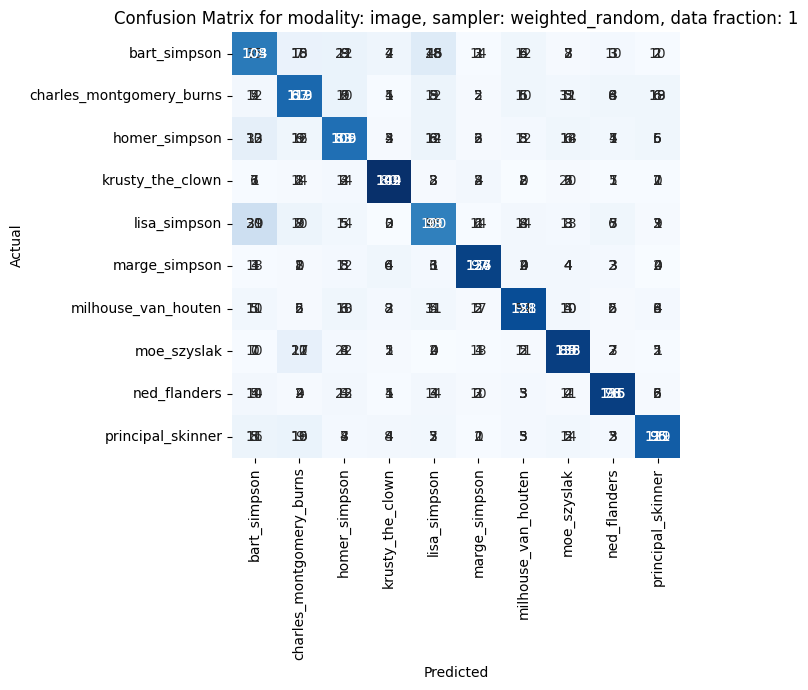

In [15]:
# Image Classifier
for data_fraction in [0.1, 1]:
    for sampler in ["random", "weighted_random"]:
        print(f"Training Image Classifier for data fraction: {data_fraction}, sampler: {sampler}")
        image_classifier = get_image_classifier()
        model_trainer = ModelTrainer(modality="image", sampler=sampler, data_fraction=data_fraction)
        model_trainer.train_classifier(image_classifier)
        model_trainer.evaluate_classifier()
        model_trainer.save_confusion_matrix()

## Audio Classifier [2]
| Data Fraction | Sampler  | Classification Accuracy → Score                   |
| ------------- | -------- | ------------------------------------------------- |
| **10%**       | Random   | `>0.75` → 1, `0.75–0.5` → 0.5, `0.5–0.3` → 0.25, `<0.3` → 0 |
|               | Weighted | `>0.75` → 1, `0.75–0.5` → 0.5, `0.5–0.3` → 0.25, `<0.3` → 0 |
| **100%**      | Random   | `>0.8` → 1, `0.8–0.5` → 0.5, `0.5–0.3` → 0.25, `<0.3` → 0 |
|               | Weighted | `>0.8` → 1, `0.8–0.5` → 0.5, `0.5–0.3` → 0.25, `<0.3` → 0 |


In [16]:
def get_audio_classifier():
    model = None
    ### YOUR CODE HERE
    return sklearn.model_selection.GridSearchCV(
        sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(),    
            sklearn.svm.SVC(kernel="rbf", class_weight="balanced", random_state=0)
        ),
        param_grid={
            "svc__C": [1, 2, 4, 8, 16, 32],
            "svc__gamma": ["scale", 1/170, 2/170], 
        },
        cv=3,
        n_jobs=-1
    )
    return model

Training Audio Classifier for data fraction: 0.1, sampler: random
Accuracy for modality: audio, sampler: random, data fraction: 0.1 is 0.6328775267538644
Training Audio Classifier for data fraction: 0.1, sampler: weighted_random
Accuracy for modality: audio, sampler: weighted_random, data fraction: 0.1 is 0.6254458977407847
Training Audio Classifier for data fraction: 1, sampler: random
Accuracy for modality: audio, sampler: random, data fraction: 1 is 0.6947086801426873
Training Audio Classifier for data fraction: 1, sampler: weighted_random
Accuracy for modality: audio, sampler: weighted_random, data fraction: 1 is 0.700653983353151


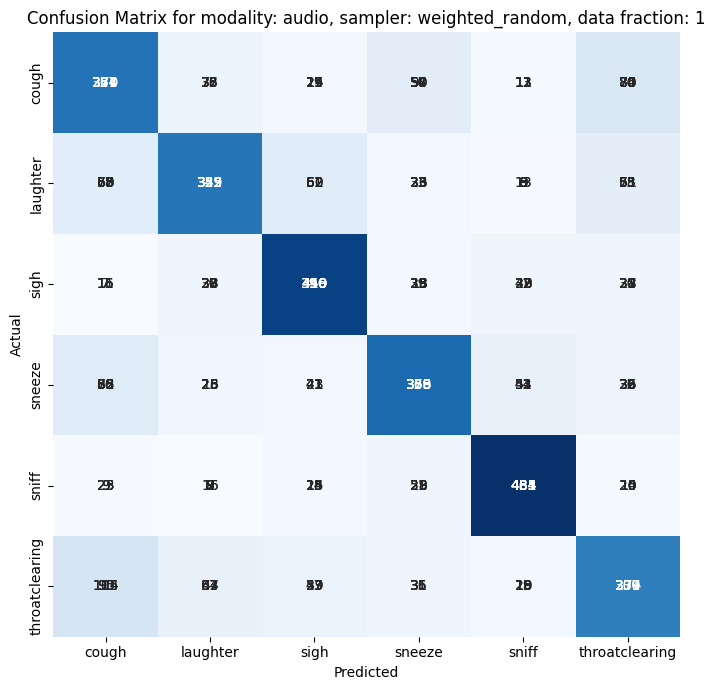

In [17]:
# Audio Classifier
for data_fraction in [0.1, 1]:
    for sampler in ["random", "weighted_random"]:
        print(f"Training Audio Classifier for data fraction: {data_fraction}, sampler: {sampler}")
        audio_classifier = get_audio_classifier()
        model_trainer = ModelTrainer(modality="audio", sampler=sampler, data_fraction=data_fraction)
        model_trainer.train_classifier(audio_classifier)
        model_trainer.evaluate_classifier()
        model_trainer.plot_confusion_matrix()
        model_trainer.save_confusion_matrix()

## Text Classifier [2]
| Data Fraction | Sampler  | Classification Accuracy → Score                   |
| ------------- | -------- | ------------------------------------------------- |
| **10%**       | Random   | `>0.75` → 1, `0.75–0.65` → 0.5, `0.65–0.5` → 0.25, `<0.5` → 0 |
|               | Weighted | `>0.75` → 1, `0.75–0.65` → 0.5, `0.65–0.5` → 0.25, `<0.5` → 0 |
| **100%**      | Random   | `>0.8` → 1, `0.8–0.7` → 0.5, `0.7–0.5` → 0.25, `<0.5` → 0 |
|               | Weighted | `>0.9` → 1, `0.9–0.7` → 0.5, `0.7–0.5` → 0.25, `<0.5` → 0 |


In [18]:
def get_text_classifier():
    model = None
    ### YOUR CODE HERE
    return sklearn.model_selection.GridSearchCV(
       sklearn.svm.LinearSVC(dual=False, class_weight="balanced", random_state=0),
       param_grid={"C": [0.5, 1, 2, 4, 8, 16]},
       cv=3, n_jobs=-1
    )
    return model

Training Text Classifier for data fraction: 0.1, sampler: random
Accuracy for modality: text, sampler: random, data fraction: 0.1 is 0.6765
Training Text Classifier for data fraction: 0.1, sampler: weighted_random
Accuracy for modality: text, sampler: weighted_random, data fraction: 0.1 is 0.723
Training Text Classifier for data fraction: 1, sampler: random
Accuracy for modality: text, sampler: random, data fraction: 1 is 0.7845
Training Text Classifier for data fraction: 1, sampler: weighted_random
Accuracy for modality: text, sampler: weighted_random, data fraction: 1 is 0.7845


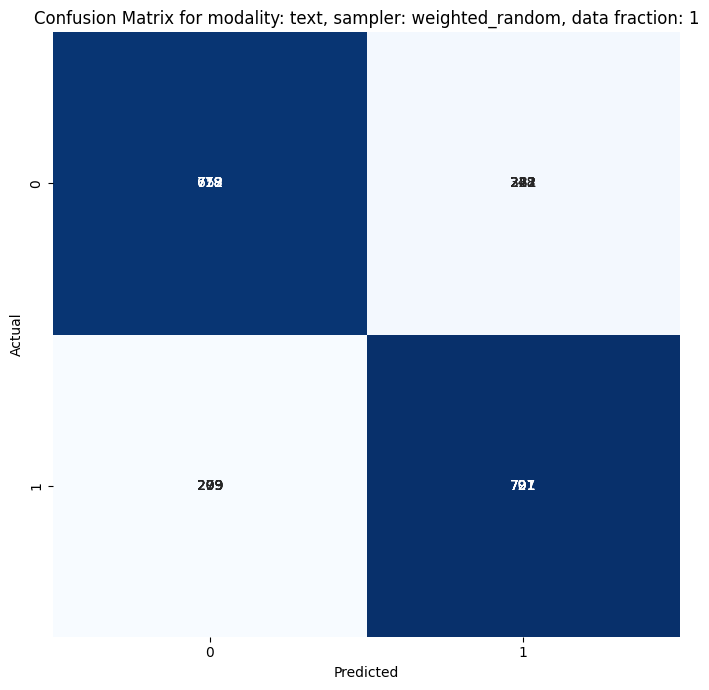

In [19]:
# Text Classifier
for data_fraction in [0.1, 1]:
    for sampler in ["random", "weighted_random"]:
        print(f"Training Text Classifier for data fraction: {data_fraction}, sampler: {sampler}")
        text_classifier = get_text_classifier()
        model_trainer = ModelTrainer(modality="text", sampler=sampler, data_fraction=data_fraction)
        model_trainer.train_classifier(text_classifier)
        model_trainer.evaluate_classifier()
        model_trainer.plot_confusion_matrix()
        model_trainer.save_confusion_matrix()

# $${fin}$$